# Import Necessary Packages

In [1]:
import time
import operator
import math
import random
import sympy
import multiprocessing
import numpy as np
import pandas as pd

# Plot the binary tree
import pygraphviz as pgv
import pydotplus
import networkx as nx

import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy.optimize import curve_fit
from IPython.display import Image, display, Latex
from sklearn import metrics 

# from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

In [2]:
config = {
    "font.family":'Times New Roman',
    "font.size": 20,
    "mathtext.fontset":'stix',
    "axes.titlesize": 24
}
rcParams.update(config)

# Create Data
1. In this section, we are going to create two kinds of data, i.e., training dataset and test dataset. The $1^{st}$ one is for training symbolic regression network, the $2^{nd}$ one is to calculate the corresponding score of symbolic regression. While for the equation we are going to use is Eq. \ref{eq:Babbage's functional equation}. 
$$
f(x) = -\frac{x^2}{8} + \frac{3}{8x^2}
\label{eq:Babbage's functional equation}
$$
where  $b$ and $c$ are arbitrary constants, which could be set by users.
By the way, Eq. \ref{eq:Babbage's functional equation} has to satisfy the constraints, i.e., 
$$
f(x) + 3f(\frac{1}{x}) = x^2
\label{eq:Babbage's constraint}
$$
2. In this python class, we also fit the data using `scipy`.

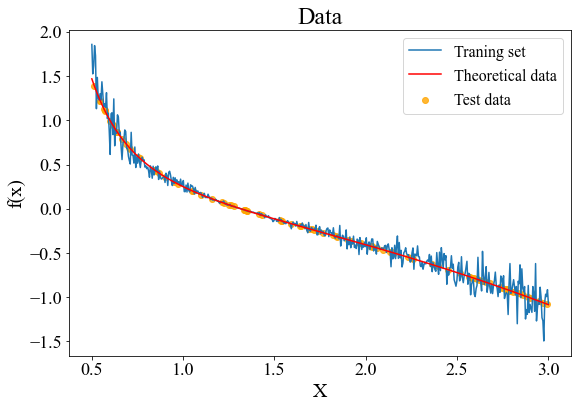

In [3]:
class PreData():
    """
    This is a class that constains all the functions to create the data.
    Variables:
    ---------------
        constant: dictionary
            The keys ('b' and 'c') are arbitrary constants for Baggages function.
            The values of respective keys are the value of arbitrary constants.
        number: int
            It is how much number of data we should create. The default value is
            500.
        ratio: float
            It is split ratio to create training dataset and test dataset. By the 
            way, in our code, we just use the simplest spliting mechanism. 
    Returns: numpy ndarray
    ---------------
        X_train； 400 * 1
        y_train： 400
    
    """
    def __init__(self, number=500, ratio=0.8):
        super().__init__()
        self.x_lower = 0.5
        self.x_upper = 3
        self.number = number
        self.split_ratio = ratio
    
    def create_data(self):
        random_state = np.random.RandomState(0)  # Set random seed
#         X = random_state.uniform(self.x_lower, self.x_upper, self.number).reshape(-1, 1)
        x = np.linspace(self.x_lower, self.x_upper,  self.number).reshape(-1, 1)
        y = - np.power(x, 2) / 8 + 3/ (8*np.power(x, 2))
        
        # Add noise to the data
        m, n = y.shape
        # noise = np.abs(random_state.randn(m, n))
        noise = random_state.randn(m, n)
        # noise = random_state.uniform(-1, 1, m)
        y_new = y * ( 1 + 0.15*noise)
        
        return x, y, y_new

    def createTestData(self):
        random_state = np.random.RandomState(0)
        x = np.random.uniform(self.x_lower, self.x_upper, size=100)
        y = - np.power(x, 2) / 8 + 3/ (8*np.power(x, 2))
        
        return x, y
    
    def plot_data(self, X, y_theo, y_noise, x_test, y_test):
        
        fig = plt.figure(figsize=(9, 6))
        plt.plot(X, y_noise, label='Traning set', linewidth=1.5)
        plt.plot(X, y_theo, label="Theoretical data", linewidth=1.5, c='r')
        plt.scatter(x_test, y_test, label="Test data", alpha=0.8, c='orange')
        
        plt.xlabel('X')
        plt.xticks(fontsize=18)
        plt.ylabel('f(x)')
        plt.yticks(fontsize=18)
        plt.title('Data')
        plt.legend(fontsize=16)
        plt.show()
        
        return 

    def run(self):
        # 1. Create data
        X, y_theo, y_noise = self.create_data()
        x_test, y_test = self.createTestData()

        # 4. Visualize the data
        self.plot_data(X, y_theo, y_noise, x_test, y_test)
        
        return X, y_theo, y_noise, x_test, y_test


data_object = PreData()
X_train, y_theo, y_train, x_test, y_test = data_object.run()

    baseSR_object = BaseSeyReg(Data_info=Data_info,
                               mutation_dic=mutation_dic,
                               pset=pset,
                               fig_path=fig_path,
                               generation=150,
                               population_size=2000,
                               penalty_coeff=0.007,
                               prob_cx_subtree=0.6,
                               prob_cx_leaf=0.1)

# DEAP Numpy
1. At the first stage, we use x_train and theo_y, i.e., the theoretical data without noise to test whether DEAP works for our idea. \textbf{NOTE}: The data structure is numpy.ndarray, which should be careful when creating corresponding  parts in DEAP.   

In [7]:
# Global variables
A, B = X_train.squeeze(), y_train.squeeze() 
# TEST_DATA = {
#     "X": X_test, 
#     "y": y_test
# }

In [8]:
# Define new functions
def protectedDiv(left, right):
    with np.errstate(divide='ignore',invalid='ignore'):
        x = np.divide(left, right)
        if isinstance(x, np.ndarray):
            x[np.isinf(x)] = 1
            x[np.isnan(x)] = 1
        elif np.isinf(x) or np.isnan(x):
            x = 1
    return x

pset = gp.PrimitiveSet("MAIN", 1)
pset.addPrimitive(np.add, 2, name="add")
pset.addPrimitive(np.subtract, 2, name="sub")
pset.addPrimitive(np.multiply, 2, name="mul")
pset.addPrimitive(protectedDiv, 2, name="div")
pset.addPrimitive(np.square, 1, name="squ")
pset.addPrimitive(np.negative, 1, name="neg")
pset.addEphemeralConstant("rand", lambda: random.randint(0,9))
# pset.addEphemeralConstant("rand_round", lambda: round(random.uniform(2, 9), ndigits=2))
pset.renameArguments(ARG0='x')

In [9]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

In [4]:
def varAnd(population, toolbox, cxpb, mutpb):
    """Part of an evolutionary algorithm applying only the variation part
    (crossover **and** mutation). The modified individuals have their
    fitness invalidated. The individuals are cloned so returned population is
    independent of the input population.
    -------------------
    Variables: 
        :param population: A list of individuals to vary.
        :param toolbox: A :class:`~deap.base.Toolbox` that contains the 
                evolution operators.
        :param cxpb: The probability of mating two individuals. 
        :param mutpb: The probability of mutating an individual. This parameter 
                    should be a dictionary, so taht we could use multiple 
                    mutation mechanism. The key tis the muytation way, the value
                    is the mutation probability.
    ------------------
    :returns: A list of varied individuals that are independent of their
              parents.
    """
    offspring = [toolbox.clone(ind) for ind in population]

    # Apply crossover and mutation on the offspring
    for i in range(1, len(offspring), 2):
        if random.random() < cxpb:
            offspring[i - 1], offspring[i] = toolbox.mate(offspring[i - 1],
                                                          offspring[i])
            del offspring[i - 1].fitness.values, offspring[i].fitness.values
    
    
    for mut_name in list(mutpb.keys()):
        if mut_name == 'full':
            for i in range(len(offspring)):
                if random.random() < mutpb['full']:
                    offspring[i], = toolbox.mutate_full(offspring[i])
                    del offspring[i].fitness.values
        else:
            for i in range(len(offspring)):
                if random.random() < mutpb['grow']:
                    offspring[i], = toolbox.mutate_grow(offspring[i])
                    del offspring[i].fitness.values

    return offspring


def eaSimple(population, toolbox, cxpb, mutpb, ngen, stats=None,
             halloffame=None, verbose=__debug__):
    """This algorithm reproduce the simplest evolutionary algorithm as
    presented in chapter 7 of [Back2000]_.
    -----------------
    Variables:
        :param population: A list of individuals.
        :param toolbox: A :class:`~deap.base.Toolbox` that contains the evolution
                        operators.
        :param cxpb: The probability of mating two individuals.
        :param mutpb: The probability of mutating an individual. This parameter 
                    should be a dictionary, so taht we could use multiple
                    mutation mechanism. The key tis the muytation way, the 
                    value is the mutation probability.
        :param ngen: The number of generation.
        :param stats: A :class:`~deap.tools.Statistics` object that is updated
                      inplace, optional.
        :param halloffame: A :class:`~deap.tools.HallOfFame` object that will
                           contain the best individuals, optional.
        :param verbose: Whether or not to log the statistics.
    ----------------
    :returns: The final population
    :returns: A class:`~deap.tools.Logbook` with the statistics of the
              evolution
    """
    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    if halloffame is not None:
        halloffame.update(population)

    record = stats.compile(population) if stats else {}
    logbook.record(gen=0, nevals=len(invalid_ind), **record)
    if verbose:
        print(logbook.stream)

    # Begin the generational process
    for gen in range(1, ngen + 1):
        # Select the next generation individuals
        offspring = toolbox.select(population, len(population))

        # Vary the pool of individuals
        offspring = varAnd(offspring, toolbox, cxpb, mutpb)

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit
            
        # Update the hall of fame with the generated individuals
        if halloffame is not None:
            halloffame.update(offspring)

        # Replace the current population by the offspring
        population[:] = offspring

        # Append the current generation statistics to the logbook
        record = stats.compile(population) if stats else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        if verbose:
            print(logbook.stream)
        
        # Set stopping criteria
        if record['fitness']['min'] < 0.0001:
            print('The stopping criteria is met, with fitness {}'.format(record['fitness']['min']))
            break 

    return population, logbook, record



In [5]:
class BaseSeyReg():
    """
    -------------------
    NOTE: There are two global variable in this class, i.e., A and B. 
        A is the X_train, B is the y_trian or any other knid of y value.
    """
    def __init__(self,
                 Data_info,
                 mutation_dic,
                 pset,
                 fig_path,
                 generation=3,
                 population_size=1200,
                 penalty_coeff=0.1,
                 height_max_value=4,
                 prob_cx_subtree=0.7,
                 prob_cx_leaf=0.2):
        self._Data_info = Data_info
        self._mutation_dic = mutation_dic
        self._pset = pset
        self._generation = generation
        self._penelty_coeff = penalty_coeff
        self._height_max_value = height_max_value
        self._pop_size = population_size
        self._prob_cx_subtree = prob_cx_subtree
        self._prob_cx_leaf = prob_cx_leaf
        self.save_path = fig_path

    def __del__(self):
        """We need to delete the instance to release the memory."""
        print("The instance has been deleted")

    def assembleGP(self):
        toolbox = base.Toolbox()
        toolbox.register("expr",
                         gp.genHalfAndHalf,
                         pset=self._pset,
                         min_=1,
                         max_=4)
        toolbox.register("individual", tools.initIterate, creator.Individual,
                         toolbox.expr)
        toolbox.register("population", tools.initRepeat, list,
                         toolbox.individual)
        toolbox.register("compile", gp.compile, pset=self._pset)

        def evalSymbReg(individual, points, y_true):
            # Transform the tree expression in a callable function
            func = toolbox.compile(expr=individual)
            # Evaluate the mean squared error between the expression
            error = np.average((func(points) - y_true)**2)
            L2_norm = np.average((func(points) + 3*func(1/points) - points ** 2)**2)
            
            errors = error + self._penelty_coeff * L2_norm

            return errors,

        # Fitness function
        toolbox.register("evaluate", evalSymbReg, 
                         points=self._Data_info["X_train"],
                         y_true=self._Data_info["y_train"])
        # Selection
        toolbox.register("select", tools.selTournament, tournsize=20)
        # Crossover
        toolbox.register("mate", gp.cxOnePoint)  # Subtree crossover
        toolbox.register("p_leaf_cx",
                         gp.cxOnePointLeafBiased,
                         termpb=self._prob_cx_leaf)  # leaf crossover
        # Mutation
        toolbox.register("expr_mut_full", gp.genFull, min_=0,
                         max_=2)  # The depth of leaf are strict constrainted
        toolbox.register("expr_mut_grow", gp.genGrow, min_=0,
                         max_=3)  # The depth is varying
        toolbox.register("mutate_full",
                         gp.mutUniform,
                         expr=toolbox.expr_mut_full,
                         pset=self._pset)
        toolbox.register("mutate_grow",
                         gp.mutUniform,
                         expr=toolbox.expr_mut_grow,
                         pset=self._pset)

        # Bloat control: It is useful for crossover and mutation
        toolbox.decorate(
            "mate",
            gp.staticLimit(key=operator.attrgetter("height"),
                           max_value=self._height_max_value))
        toolbox.decorate(
            "mutate_full",
            gp.staticLimit(key=operator.attrgetter("height"),
                           max_value=self._height_max_value))
        toolbox.decorate(
            "mutate_grow",
            gp.staticLimit(key=operator.attrgetter("height"),
                           max_value=self._height_max_value))
        toolbox.decorate(
            "p_leaf_cx",
            gp.staticLimit(key=operator.attrgetter("height"),
                           max_value=self._height_max_value))

        return toolbox

    def score(self, x, y, best_tree):
        """This is a test function to give R^2 value as the score, where
        R^2 = (1 - U/V), which means R^2 is higher when the model's performance
        is better.
        """
        func = gp.compile(str(best_tree), pset=self._pset)
        y_pred = func(x)

        return metrics.r2_score(y, y_pred)

    def main_program(self):
        random.seed(0)

        # 1. Prepare toolbox
        toolbox = self.assembleGP()

        # 2. Getting population
        pop = toolbox.population(n=self._pop_size)
        hof = tools.HallOfFame(1)

        # 3. Prepare log information
        stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
        stats_size = tools.Statistics(len)
        mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
        mstats.register("min", np.min)

        # 4. Evolution
        pop, log, record = eaSimple(
            pop,
            toolbox,
            cxpb=self._prob_cx_subtree,
            mutpb=self._mutation_dic,
            ngen=self._generation,
            stats=mstats,
            halloffame=hof,
            verbose=True
        )  # record gives the minimum fitness of each generation

        return pop, log, hof, record

    def _timeTransfer(self, total_time):
        """Transfer time into minutes and seconds"""
        minute = total_time // 60
        second = total_time % 60

        return minute, second

    def treeTransfer(self, hof):
        """
        Transfer the optimal individual into symbolc expression using string
        format.
        ----------------------
        hof_tree_expr: It is a simplified symbolic mathematical expression.
        hof_tree: It is a gp.PrimitiveTree structure, which is not a string
            that could be compiled to a function using gp.compile. Thus you need
            to use str(hof_tree) so that you could compile it.
        """
        converter = {
            'sub': lambda x, y: x - y,
            'div': lambda x, y: x / y,
            'mul': lambda x, y: x * y,
            'add': lambda x, y: x + y,
            'neg': lambda x: -x,
            'abs': lambda x: sympy.Abs(x),
            'pow': lambda x, y: x**y,
            'sin': lambda x: sympy.sin(x),
            'cos': lambda x: sympy.cos(x),
            'inv': lambda x: 1 / x,
            'sqrt': lambda x: x**0.5,
            'self_exp': lambda x: sympy.exp(x**2),
            'squ': lambda x: x**2
        }  # Converter set

        hof_tree = gp.PrimitiveTree(hof)[0]
        hof_tree_str = str(gp.PrimitiveTree(hof)[0])
        hof_tree_expr = sympy.sympify(hof_tree_str, locals=converter)
        hof_tree_expr = sympy.simplify(
            hof_tree_expr)  # simplify the expression

        return hof_tree_expr, hof_tree

    def plotComparison(self, best_tree):
        """
        best_tree: It shoule be PrimitiveTree structure, which should be
            converted into str here, so that the compilation could be made.
        """
        X = self._Data_info["X_train"]
        noised_y = self._Data_info["y_train"]
        theo_y = self._Data_info["theoretical"]
        x_sparse = [x for i, x in enumerate(X) if i % 10 == 0]
        theo_y = [y for i, y in enumerate(theo_y) if i % 10 == 0] 
        best_func = gp.compile(str(best_tree), self._pset)
        best_y = [best_func(x) for x in X]

        fig = plt.figure(figsize=(7, 5))
        plt.scatter(x_sparse, theo_y, label="Theoretical data", c='r', alpha=1)
#         plt.scatter(X, noised_y, label="Training set", alpha=1,s=1)
        plt.plot(X, noised_y, label='Training set', linewidth=1.5, alpha=0.8, c='g')
#         plt.plot(X, theo_y, label="Theoretical data", c='r', linewidth=2)
        
        plt.plot(X, best_y, label="Symbolic data", c='b', linewidth=2)
        plt.xlabel('X')
        plt.xticks(fontsize=18)
        plt.ylabel('f(x)')
        plt.yticks(fontsize=18)
        plt.title('Data Distribution')
        plt.legend(fontsize=16)

        plt.savefig(self.save_path, dpi=1600, format='svg', bbox_inches='tight')
        plt.show()


The instance has been deleted
   	      	           fitness            	         size         
   	      	------------------------------	----------------------
gen	nevals	gen	min     	nevals	gen	min	nevals
0  	2000  	0  	0.228293	2000  	0  	2  	2000  
1  	1301  	1  	0.0863465	1301  	1  	1  	1301  
2  	1301  	2  	0.0749372	1301  	2  	1  	1301  
3  	1329  	3  	0.0692446	1329  	3  	1  	1329  
4  	1324  	4  	0.0692446	1324  	4  	1  	1324  
5  	1305  	5  	0.0428998	1305  	5  	1  	1305  
6  	1342  	6  	0.0424367	1342  	6  	1  	1342  
7  	1318  	7  	0.0406195	1318  	7  	1  	1318  
8  	1332  	8  	0.0274418	1332  	8  	1  	1332  
9  	1324  	9  	0.0274418	1324  	9  	1  	1324  
10 	1310  	10 	0.0274418	1310  	10 	1  	1310  
11 	1352  	11 	0.0274418	1352  	11 	1  	1352  
12 	1294  	12 	0.0274418	1294  	12 	1  	1294  
13 	1326  	13 	0.0274418	1326  	13 	1  	1326  
14 	1290  	14 	0.0274418	1290  	14 	1  	1290  
15 	1286  	15 	0.0274418	1286  	15 	1  	1286  
16 	1293  	16 	0.0274418	1293  	16 	1  	129

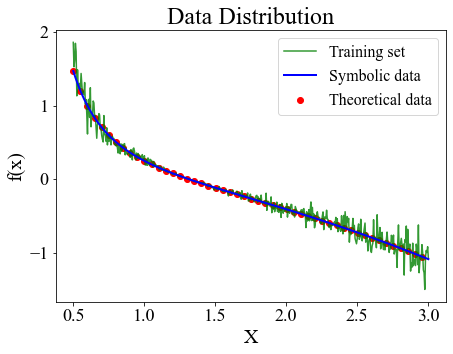

(3 - x**4)/(8*x**2)

R^2 = 1.0000
Total Time: 166.251 s


In [14]:
if __name__ == "__main__":
    time_start = time.time()

    mutation_dic = {'full': 0.05, 'grow': 0.1}
    Data_info = {
        "X_train": A,
        "y_train": B,
        "theoretical": y_theo.squeeze(),
        "X_test": x_test,
        "y_test": y_test
    }
    fig_path = './New_functional_eq_plot.svg'
    baseSR_object = BaseSeyReg(Data_info=Data_info,
                               mutation_dic=mutation_dic,
                               pset=pset,
                               fig_path=fig_path,
                               generation=150,
                               population_size=2000,
                               penalty_coeff=0.007,
                               prob_cx_subtree=0.6,
                               prob_cx_leaf=0.1)

    # baseSR_object.parameterTest()
    pop, log, hof, record = baseSR_object.main_program()

    best_sr_expr, best_tree_w = baseSR_object.treeTransfer(hof)

    baseSR_object.plotComparison(best_tree_w)
    display(best_sr_expr)  # display the expression

    # Getting scores
    r_2 = baseSR_object.score(Data_info["X_test"], Data_info["y_test"], best_tree_w)
    print("R^2 = {:.4f}".format(r_2))

    time_end = time.time()
    total_time = time_end - time_start
    print("Total Time: {:.3f} s".format(total_time))

    # 0.00585
    # 0.00537 for penalty 0.001

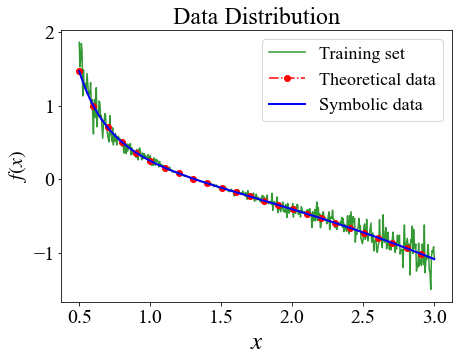

In [11]:
def symNoPenalty(x):
    return (3- x**4) / (8*x**2)

fig_path = './New_functional_eq_plot.svg'
y_sym = symNoPenalty(A)

fig = plt.figure(figsize=(7, 5))
plt.plot(A, B, label='Training set', linewidth=1.5, alpha=0.8, c='g')
plt.plot(A, y_theo, "r-.o",label="Theoretical data", markevery=20)
plt.plot(A, y_sym, label="Symbolic data", c='b', linewidth=2)
plt.xlabel('$x$', fontsize=25)
plt.ylabel('$f(x)$')
plt.title('Data Distribution')
plt.legend(fontsize=18)

plt.savefig(fig_path, dpi=1600, format='svg', bbox_inches='tight')
plt.show()

   	      	           fitness            	         size         
   	      	------------------------------	----------------------
gen	nevals	gen	min     	nevals	gen	min	nevals
0  	2000  	0  	0.147437	2000  	0  	2  	2000  
1  	1110  	1  	0.0718119	1110  	1  	1  	1110  
2  	1129  	2  	0.0637205	1129  	2  	1  	1129  
3  	1198  	3  	0.0604853	1198  	3  	1  	1198  
4  	1115  	4  	0.0276861	1115  	4  	1  	1115  
The instance has been deleted
5  	1163  	5  	0.0276861	1163  	5  	1  	1163  
6  	1177  	6  	0.0186097	1177  	6  	1  	1177  
7  	1127  	7  	0.0186097	1127  	7  	1  	1127  
8  	1124  	8  	0.0158634	1124  	8  	1  	1124  
9  	1151  	9  	0.0158634	1151  	9  	1  	1151  
10 	1142  	10 	0.0158634	1142  	10 	1  	1142  
11 	1154  	11 	0.0158634	1154  	11 	1  	1154  
12 	1191  	12 	0.0158634	1191  	12 	1  	1191  
13 	1187  	13 	0.0158634	1187  	13 	1  	1187  
14 	1177  	14 	0.0158634	1177  	14 	1  	1177  
15 	1139  	15 	0.0158634	1139  	15 	1  	1139  
16 	1117  	16 	0.0158634	1117  	16 	1  	111

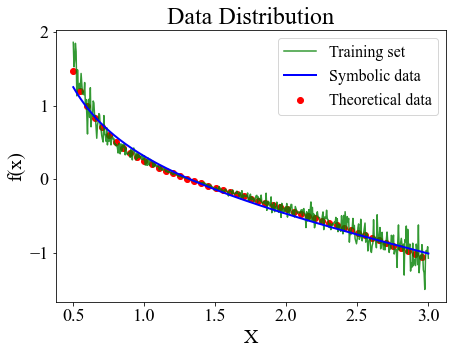

5*(7 - 4*x**2)/(48*x)

R^2 = 0.9918
Total Time: 158.095 s


In [13]:
if __name__ == "__main__":
    time_start = time.time()
    fig_path_no = './New_functional_eq_plot_no_penality.svg'
    baseSR_object_no = BaseSeyReg(Data_info=Data_info,
                               mutation_dic=mutation_dic,
                               pset=pset,
                               fig_path=fig_path_no,
                               generation=150,
                               population_size=2000,
                               penalty_coeff=0.0,
                               prob_cx_subtree=0.5,
                               prob_cx_leaf=0.1)

    # baseSR_object.parameterTest()
    pop, log, hof, record = baseSR_object_no.main_program()

    best_sr_expr, best_tree_no = baseSR_object_no.treeTransfer(hof)

    baseSR_object.plotComparison(best_tree_no)
    display(best_sr_expr)  # display the expression

    # Getting scores
    r_2 = baseSR_object_no.score(Data_info["X_test"], Data_info["y_test"], best_tree_no)
    print("R^2 = {:.4f}".format(r_2))

    time_end = time.time()
    total_time = time_end - time_start
    print("Total Time: {:.3f} s".format(total_time))


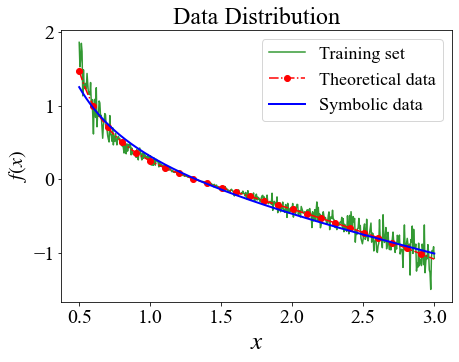

In [12]:
def symNoPenalty(x):
    return 5*(7-4*x**2) / (48*x)

fig_path_no = './New_functional_eq_plot_no_penality.svg'
y_sym = symNoPenalty(A)

fig = plt.figure(figsize=(7, 5))
plt.plot(A, B, label='Training set', linewidth=1.5, alpha=0.8, c='g')
plt.plot(A, y_theo, "r-.o",label="Theoretical data", markevery=20)
plt.plot(A, y_sym, label="Symbolic data", c='b', linewidth=2)
plt.xlabel('$x$', fontsize=25)
plt.ylabel('$f(x)$')
plt.title('Data Distribution')
plt.legend(fontsize=18)

plt.savefig(fig_path_no, dpi=1600, format='svg', bbox_inches='tight')
plt.show()


In [ ]:
func = gp.compile(str(best_tree_w), pset)
# Evaluate the mean squared error between the expression
y_p = func(x_test)
np.sqrt(np.average((y_test - y_p)**2))

In [ ]:
time_start = time.time()

mutation_dic = {'full': 0.05, 'grow': 0.1}
Data_info = {
    "X_train": X_train,
    "y_train": y_train,
    "fit": fit_data,
    "fit_para": fit_parameters,
    "theoretical": theo_y,
}
fig_path = './figure/functional equation random num no penalty.png'
baseSR_object = BaseSeyReg(Data_info=Data_info,
                           mutation_dic=mutation_dic,
                           pset=pset,
                           fig_path=fig_path,
                           generation=10,
                           population_size=2000,
                           penalty_coeff=0,
                           prob_cx_subtree=0.5,
                           prob_cx_leaf=0.1)

# baseSR_object.parameterTest()
pop, log, hof, record = baseSR_object.main_program()

best_sr_expr, best_tree_no = baseSR_object.treeTransfer(hof)

baseSR_object.plotComparison(best_tree_no)
display(best_sr_expr)  # display the expression

# Getting scores
r_2 = baseSR_object.score(TEST_DATA["X"], TEST_DATA["y"], best_tree_no)
print("R^2 = {:.3f}".format(r_2))

time_end = time.time()
total_time = time_end - time_start
print("Total Time: {:.3f} s".format(total_time))



In [ ]:
# with penalty
func_with = gp.compile(str(best_tree_w), pset=pset)
# no penalty
func_no = gp.compile(str(best_tree_no), pset=pset)

error_with = (func_with(X_train) - theo_y).squeeze()
error_with_noise = (func_with(X_test).squeeze() - y_test)
error_no = (func_no(X_train) - theo_y).squeeze()
error_no_noise = (func_no(X_test).squeeze() - y_test)

plt.figure(figsize=(9, 6))
plt.plot(X_train, error_with, label="With penalty", c='blue')
plt.plot(X_train, error_no, label='No penalty', c='red')
# plt.plot(X_test, error_with_noise, alpha=0.7, label="Noised data with penalty")
# plt.plot(X_test, error_no_noise, alpha=0.7, label="Noised data no penalty")
plt.xlabel("Testing set", fontdict={'size': 18})
plt.xticks(fontsize=16)
plt.ylabel("Absolute error", fontdict={'size': 18})
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
# 
plt.savefig('./figure/functional equation error')

plt.show()

In [ ]:
def theoData(x):
    return (1.5 - x) / (1+3.5*x)

X = np.linspace(0, 200, 200)
y_with = func_with(X)
y_no = func_no(X)
plt.figure(figsize=(9, 6))
plt.plot(X, y_with, c='k', linewidth=1, label="With penalty")
plt.plot(X, y_no, c='g', label='No penalty')
plt.plot(X, theoData(X), c='r', linewidth=1, alpha=1, label="Theoretical")
plt.xlabel("Testing set", fontdict={'size': 18})
plt.xticks(fontsize=16)
plt.ylabel("f(x)", fontdict={'size': 18})
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
# 
plt.savefig('./figure/functional equation prediction')

plt.show()

In [ ]:
converter = {
    'sub': lambda x, y: x - y,
    'div': lambda x, y: x / y,
    'mul': lambda x, y: x * y,
    'add': lambda x, y: x + y,
    'neg': lambda x: -x,
    'abs': lambda x: sympy.Abs(x),
    'pow': lambda x, y: x**y,
    'sin': lambda x: sympy.sin(x),
    'cos': lambda x: sympy.cos(x),
    'inv': lambda x: 1 / x,
    'sqrt': lambda x: x**0.5,
    'self_exp': lambda x: sympy.exp(x**2),
    'square': lambda x: x**2
}  # Converter set


best_expr = sympy.sympify(str(best_tree), locals=converter)
best_expr = sympy.simplify(best_expr) # simplify the expression
best_expr

In [ ]:
func = gp.compile(str(best_tree), pset=pset)
L2_norm = (func(func(A)) - A) ** 2
np.average((func(func(A)) - A) ** 2)*0.001,

In [ ]:
nodes, edges, labels = gp.graph(best_tree)

g = pgv.AGraph(ranksep="0.3", directed=True,strict=True)
g.add_nodes_from(nodes)
g.add_edges_from(edges)
g.layout(prog="dot")

for i in nodes:
    node = g.get_node(i)
    # node.attr["label"] = labels[i]
    if isinstance(labels[i], float) or isinstance(labels[i], int):
        node.attr["label"] = np.round_(labels[i], decimals=3)
        node.attr['color'] = 'blue'
    else:
        node.attr["label"] = labels[i]
        if len(labels[i]) > 1:
            node.attr['color'] = 'red'
        else:
            node.attr['color'] = 'blue'
        
    
g.draw('tree.png')
display(Image('tree.png', width=400))
